In [9]:
using Integrals
using SpecialFunctions
using Base.Threads
using Glob
using DataFrames
using CSV
using CairoMakie
using LaTeXStrings
using Polynomials
using Statistics
using PhysicalConstants.CODATA2018
using FilePathsBase
using ColorSchemes
CairoMakie.activate!(inline=true)

In [10]:
CairoMakie.activate!(inline=true)
custom_theme = Theme(
    fontsize = 8,
    linewidth = 1.5,
    fonts = (; regular = "Helvetica"),
    Axis = (
        spinewidth = 1,
        xgridvisible = false,
        ygridvisible = false,
        topspinevisible = false,
        rightspinevisible = false,
        xtickwidth = 1,
        xticksize = 2,
        ytickwidth = 1,
        yticksize = 2,
    ),
    Colorbar = (
        spinewidth = 1,
        tickwidth = 1,
        ticksize = 2,
    ),
    Legend = (
        framevisible = false,
    )
)
set_theme!(custom_theme)

In [11]:
using Unitful
Unitful.preferunits(u"nm")

In [12]:
Unitful.register(@__MODULE__);
@unit b "b" b (0.34)*(45/(45+146))*u"nm" false
@unit kb "kb" kb 1000*u"b" false

┌ Warning: Symbol b was found in multiple registered unit modules.
│ We will use the one from Main.
└ @ Unitful /Users/wudw/.julia/packages/Unitful/sxiHA/src/user.jl:715
┌ Warning: Symbol b was found in multiple registered unit modules.
│ We will use the one from Main.
└ @ Unitful /Users/wudw/.julia/packages/Unitful/sxiHA/src/user.jl:715
┌ Warning: Symbol b was found in multiple registered unit modules.
│ We will use the one from Main.
└ @ Unitful /Users/wudw/.julia/packages/Unitful/sxiHA/src/user.jl:715
┌ Warning: Symbol b was found in multiple registered unit modules.
│ We will use the one from Main.
└ @ Unitful /Users/wudw/.julia/packages/Unitful/sxiHA/src/user.jl:715
┌ Warning: Symbol b was found in multiple registered unit modules.
│ We will use the one from Main.
└ @ Unitful /Users/wudw/.julia/packages/Unitful/sxiHA/src/user.jl:715
┌ Warning: Symbol b was found in multiple registered unit modules.
│ We will use the one from Main.
└ @ Unitful /Users/wudw/.julia/packages/Unitful/sx

kb

In [13]:
# Diffusivity of protein
Dc = 1.0u"μm^2/s"
# Partition ratio c+/c-
Pc = 5
# Diffusivity of RNA
Dm = 0.03u"μm^2/s" 
# Radius of droplet
R = 250 * u"nm"
# Nascent RNA lifetime
lifetime_RNA = uconvert(u"s",10u"minute")
kd = 1/(lifetime_RNA)
# RNA diffusion length
l = sqrt(Dm/kd)
# Contour length of DNA
Lc = uconvert(u"nm",200u"kb")
# Kuhn length of DNA
LK = 35.36u"nm"
# Root mean squared end-to-end vector
rmsd = sqrt(Lc*LK)
# Persistence length of DNA
Lp = LK/2
# Diffusivity of DNA
Dapp = 0.01u"μm^2/s^(1/2)"
De = uconvert(u"μm^2/s",(Dapp/((12/pi)^(1/2)*LK))^2)
# Alpha parameter for DNA
getα(Lc) = 3/(4*Lp*Lc)
getLc(α) = 3/(4*Lp*α)
α = upreferred(getα(Lc))
# Temperature
T = (37 + 273.15)u"K"
# kBT
kBT = BoltzmannConstant*T
# Beta
function getβperkBT(X); return - 3/2 * 1/(Dm*De) * 1/(Pc -1) * l/(4/3*pi*R^3) * X*u"μm^5*s^(-2)"; end
# Production rate
kp = 1u"s^(-1)"

┌ Warning: Symbol kb was found in multiple registered unit modules.
│ We will use the one from Main.
└ @ Unitful /Users/wudw/.julia/packages/Unitful/sxiHA/src/user.jl:715


1 s⁻¹

In [14]:
params_0 = Dict([
    :χ => -0.2,
    :γ => 0,
    :Mc => 1,
    :Mm => 1,
    :kp => 0.1,
    :cmin => 3.5,
    :cplu => 4.5,
])
R = ustrip(u"µm",R)
l = ustrip(u"µm",l)

4.242640687119285

In [15]:
function velocity3dintegral(z0,R,l,params;tol=false,eps=1e-8)
    for (k, v) in params
        @eval ($(k) = $v)
    end
    A = (3 * Mc) / ((cplu - cmin) * (4/3 * pi * R^3)) * (2 * pi)
    B = (kp * cmin) / (4 * pi * Mm)
    C(r,x,z0) = sqrt(r^2 + z0^2 - 2 * r * z0 * x + eps)

    m(r,x,z0,l) = B * exp(- C(r,x,z0) / l) / C(r,x,z0)
    ∂zm(r,x,z0,l) = B * (exp(- C(r,x,z0) / l) * (z0 - r * x) * (l + C(r,x,z0))) / (l * C(r,x,z0)^3)

    function f(u, p)
        z0, l = p
        r, x = u
        return r^2 * (abs(χ) - 2 * abs(γ) * cplu * m(r,x,z0,l)) * ∂zm(r,x,z0,l)
    end

    domain = ([0,-1],[R,1])
    p = (z0, l)
    prob = IntegralProblem(f, domain, p)
    # if tol isa Number
        # sol = solve(prob, HCubatureJL(), reltol=tol, abstol=tol)
    # else
    sol = solve(prob, HCubatureJL())
    # end
    return sol.u
end

velocity3dintegral (generic function with 1 method)

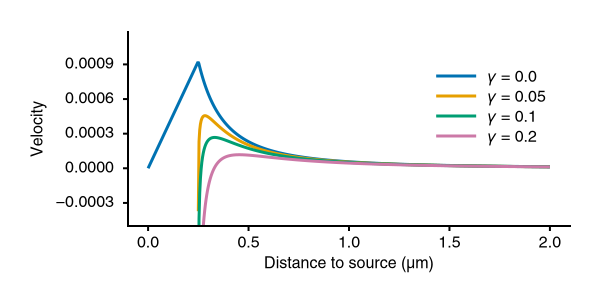

In [16]:
pt_per_cm = 28.3465
fig = Figure(size = (8.5*pt_per_cm*1.25, 8.5*pt_per_cm/2*1.25),background_color=:transparent, padding=(0,0,0,0))
ax = Axis(
    fig[1,1],
    title = "",
    xlabel = "Distance to source (µm)",
    ylabel = "Velocity",
    limits = (nothing,nothing,-0.0005,nothing)
)

γ = 0 
d = LinRange(0,2,500)
x = d
params = merge(params_0, Dict(:γ => γ))
y = velocity3dintegral.(d,R,l,Ref(params))
lines!(ax,x,y,label=rich(rich("γ",font=:italic)," = $γ"))

γ = 0.05
d = LinRange(R,2,500)
x = d
params = merge(params_0, Dict(:γ => γ))
y = velocity3dintegral.(d,R,l,Ref(params))
lines!(ax,x,y,label=rich(rich("γ",font=:italic)," = $γ"))

γ = 0.1
d = LinRange(R,2,500)
x = d
params = merge(params_0, Dict(:γ => γ))
y = velocity3dintegral.(d,R,l,Ref(params))
lines!(ax,x,y,label=rich(rich("γ",font=:italic)," = $γ"))

γ = 0.2
d = LinRange(R,2,500)
x = d
params = merge(params_0, Dict(:γ => γ))
y = velocity3dintegral.(d,R,l,Ref(params))
lines!(ax,x,y,label=rich(rich("γ",font=:italic)," = $γ"))

axislegend(rowgap=-10)
save("./figures/velocity_with_repulsion.pdf",pt_per_unit=1.0,fig)
fig